In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0224_al_n_crop00_detections.jpg
/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0667_al_d_s_crop00_detections.jpg
/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0764_al_n_crop00_detections.jpg
/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/1132_al_n_crop00_detections.jpg
/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0312_al_n_crop00_detections.jpg
/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0115_al_n_crop00_detections.jpg
/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0771_al_d_w_crop00_detections.jpg
/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0761_al_d_s_crop00_detections.jpg
/kaggle/in

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torchvision import transforms
import os
from collections import defaultdict
from PIL import Image
import wandb
import torch.optim as optim
from sklearn.manifold import TSNE


seed = 2022561
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
file_path = "/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/"
# file_path = varinkala_russian_wildlife_dataset_path + "/russian-wildlife-dataset/Cropped_final/"

In [4]:
wandb_api_key = '52e278bf12b8377d42af753c3449b8777d39b6e3'
wandb.login(key=wandb_api_key) # API key: 52e278bf12b8377d42af753c3449b8777d39b6e3

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: varin22561 (varin22561-iiitd). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
label_mapping = {'amur leopard': 0, 'amur tiger': 1, 'birds': 2, 'black bear': 3, 'brown bear': 4, 'dog': 5, 'roe deer': 6, 'sika deer': 7, 'wild boar': 8, 'people': 9}

In [3]:
images_path_list = []
labels_list = []

for key in label_mapping:
    key_ = "_".join(key.split())
    print(key_, end=" ")

    images_path = os.listdir(file_path + key_)
    print(len(images_path))
    
    images_path_list.extend([file_path + key_ + "/" + image_path for image_path in images_path])
    labels_list.extend([label_mapping[key] for _ in range(len(images_path))])

amur_leopard 978
amur_tiger 1049
birds 1446
black_bear 975
brown_bear 1209
dog 1213
roe_deer 1124
sika_deer 1539
wild_boar 1435
people 700


In [7]:
len(images_path_list), len(labels_list)

(11668, 11668)

In [8]:
images_path_list[0], labels_list[0]

('/kaggle/input/russian-wildlife-dataset/russian-wildlife-dataset/Cropped_final/amur_leopard/0224_al_n_crop00_detections.jpg',
 0)

In [4]:
class RussianWildlifeDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=None, augment_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]
        if self.transforms:
            image = self.transforms(image)

        if self.augment_transform:
            image = self.augment_transform(image)

        return image, label

In [7]:
train_paths, val_paths, train_labels, val_labels = train_test_split(images_path_list, labels_list, test_size=0.2, stratify=labels_list, random_state=seed)

In [ ]:
run = wandb.init(
    project="CV_A1_cnn_2",
    config={"epochs": 10, "batch_size": 32, "learning_rate": 0.001},
)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [8]:
batch_size = 32

train_dataset = RussianWildlifeDataset(train_paths, train_labels, transforms=transform)
val_dataset = RussianWildlifeDataset(val_paths, val_labels, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
class_names = {v: k for k, v in label_mapping.items()}

In [15]:
class_names = {v: k for k, v in label_mapping.items()}

def visualize_images(data_loader, num=5):
    size = False
    class_counts = {label: 0 for label in range(10)}
    images_class = {label: [] for label in class_names}

    for images, labels in data_loader:
        for image, label in zip(images, labels):
            label = label.item()
            if class_counts[label] < num:
                images_class[label].append(image)
                if not size:
                    print(image.shape)
                    size = True
                class_counts[label] += 1
    
            if all(count >= num for count in class_counts.values()):
                break
    
        if all(count >= num for count in class_counts.values()):
            break

    fig, axes = plt.subplots(len(class_names), num, figsize=(15, 15))
    for row, (label, img_list) in enumerate(images_class.items()):
        for col, img in enumerate(img_list):
            img = img.numpy().transpose(1, 2, 0)  # Convert CHW to HWC
            axes[row, col].imshow(np.clip(img, 0, 1))  # Clip values for display
            axes[row, col].axis("off")
            if col == 0:
                axes[row, col].set_title(class_names[label], fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

visualize_images(train_loader)

In [14]:
def plot_class_distribution(labels, dataset_type):
    unique, counts = np.unique(labels, return_counts=True)
    class_labels = [class_names[label] for label in unique]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=class_labels, y=counts, palette="viridis")
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.title(f"{dataset_type} Dataset Class Distribution")
    plt.xticks(rotation=45, ha="right")
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


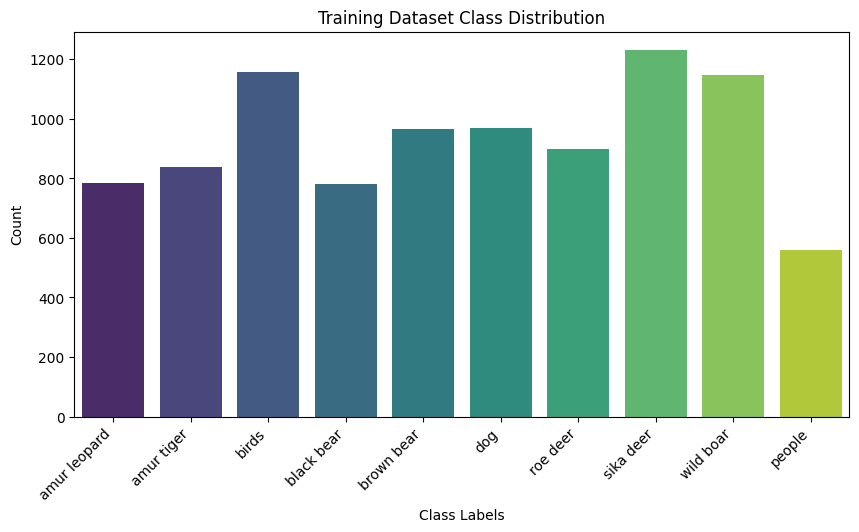

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


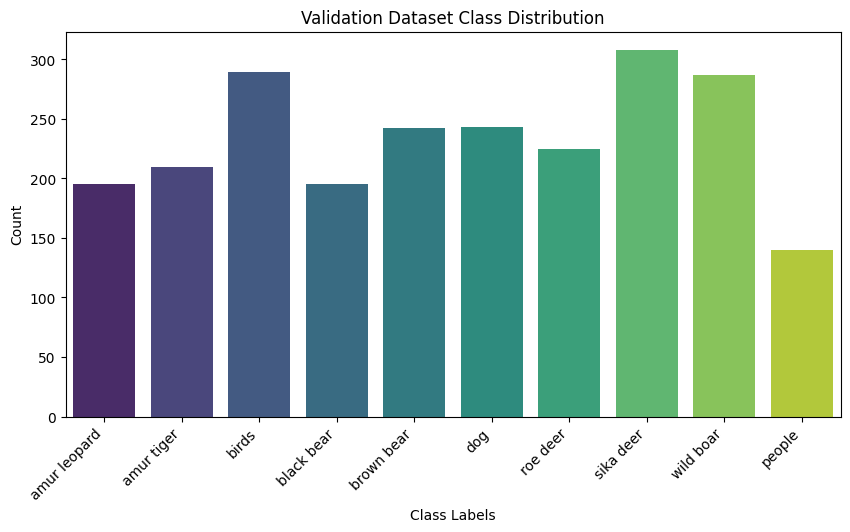

In [16]:
plot_class_distribution(train_labels, "Training")
plot_class_distribution(val_labels, "Validation")

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First Conv Layer:
        # 32 filters, 3x3 kernel, stride=1, padding=1
        # Max Pool (4x4, stride=4)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Second Conv Layer:
        # 64 filters, 3x3 kernel, stride=1, padding=1
        # Max Pool (2x2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Conv Layer:
        # 128 filters, 3x3 kernel, stride=1, padding=1
        # Max Pool (2x2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(128 * 14 * 14, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.pool1(out)

        out = self.relu(self.conv2(out))
        out = self.pool2(out)

        out = self.relu(self.conv3(out))
        out = self.pool3(out)

        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out

In [18]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        cur_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            _, predicted = outputs.max(1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = cur_loss / len(train_loader)
        train_acc = correct / total

        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        all_preds, all_labels = [], []

        misclassified = {i: [] for i in range(10)}
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                for i in range(len(labels)):
                    if predicted[i] != labels[i]:
                        misclassified[labels[i].item()].append((images[i].cpu(), predicted[i].item()))

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        f1 = f1_score(all_labels, all_preds, average="weighted")
        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": train_loss, "Train Acc": train_acc,
            "Val Loss": val_loss, "Val Acc": val_acc,
            "Val F1-Score": f1,
            "Confusion Matrix": wandb.Table(dataframe=cm_df)
        })

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return misclassified

In [20]:
%%time

misclassified = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10 | Train Loss: 1.9181 | Train Acc: 0.3113 | Val Loss: 1.6714 | Val Acc: 0.4327
Epoch 2/10 | Train Loss: 1.4869 | Train Acc: 0.4940 | Val Loss: 1.3906 | Val Acc: 0.5077
Epoch 3/10 | Train Loss: 1.2287 | Train Acc: 0.5861 | Val Loss: 1.2377 | Val Acc: 0.5917
Epoch 4/10 | Train Loss: 1.0629 | Train Acc: 0.6447 | Val Loss: 1.1711 | Val Acc: 0.6118
Epoch 5/10 | Train Loss: 0.9290 | Train Acc: 0.6908 | Val Loss: 1.1071 | Val Acc: 0.6444
Epoch 6/10 | Train Loss: 0.8110 | Train Acc: 0.7317 | Val Loss: 1.1660 | Val Acc: 0.6350
Epoch 7/10 | Train Loss: 0.6988 | Train Acc: 0.7672 | Val Loss: 1.1162 | Val Acc: 0.6551
Epoch 8/10 | Train Loss: 0.5951 | Train Acc: 0.8028 | Val Loss: 1.1998 | Val Acc: 0.6495
Epoch 9/10 | Train Loss: 0.5002 | Train Acc: 0.8337 | Val Loss: 1.3196 | Val Acc: 0.6260
Epoch 10/10 | Train Loss: 0.3975 | Train Acc: 0.8690 | Val Loss: 1.3129 | Val Acc: 0.6474
CPU times: user 1min 21s, sys: 38.2 s, total: 1min 59s
Wall time: 6min 53s


In [16]:
def plot_misclassified_images(misclassified_samples, class_names, num_samples=3):
    for class_id, samples in misclassified_samples.items():
        if len(samples) == 0:
            continue

        fig, axes = plt.subplots(1, len(samples[:num_samples]), figsize=(12, 4))
        fig.suptitle(f"Misclassified Images for Class: {class_names[class_id]}", fontsize=14)

        for i, (img, pred_label) in enumerate(samples[:num_samples]):
            if i > 2:
                break
            
            img = img.permute(1, 2, 0).numpy()

            axes[i].imshow(img)
            axes[i].set_title(f"Pred: {class_names[pred_label]}", fontsize=10, color='red')
            axes[i].axis("off")

        plt.show()

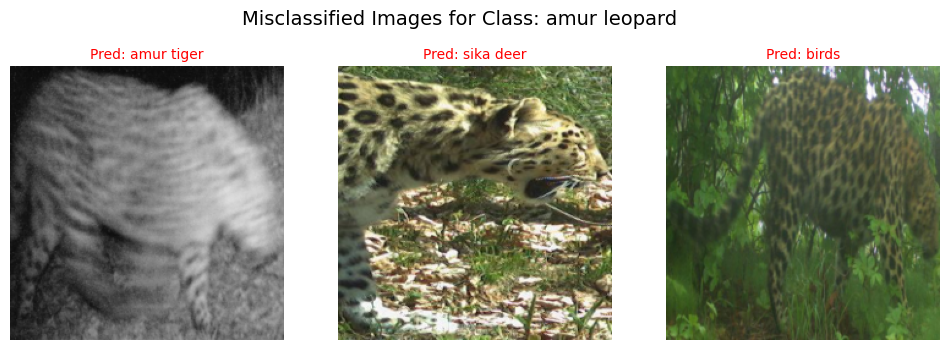

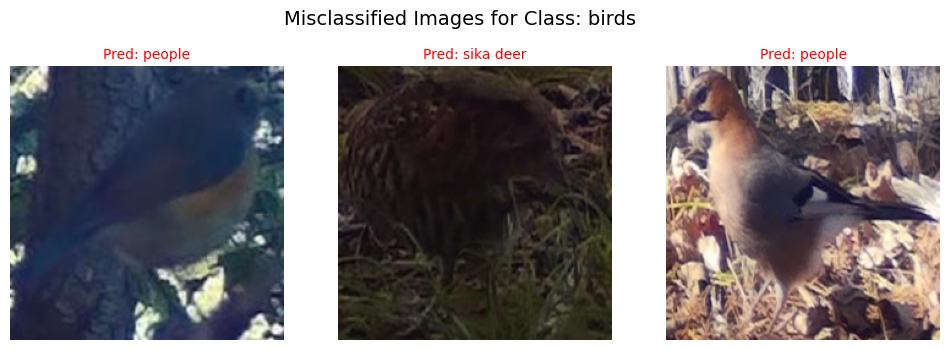

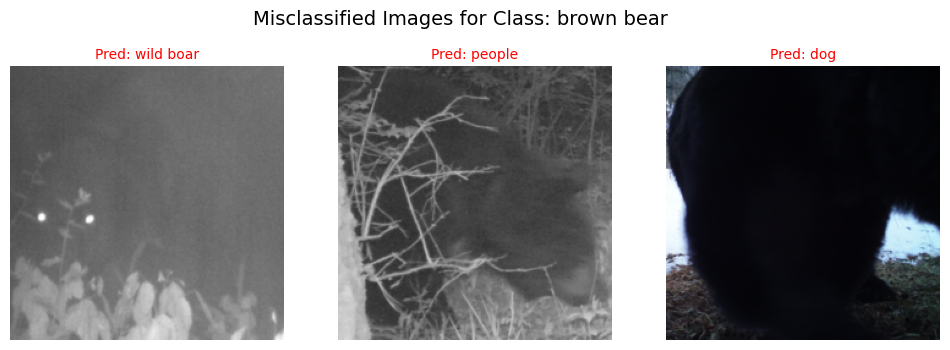

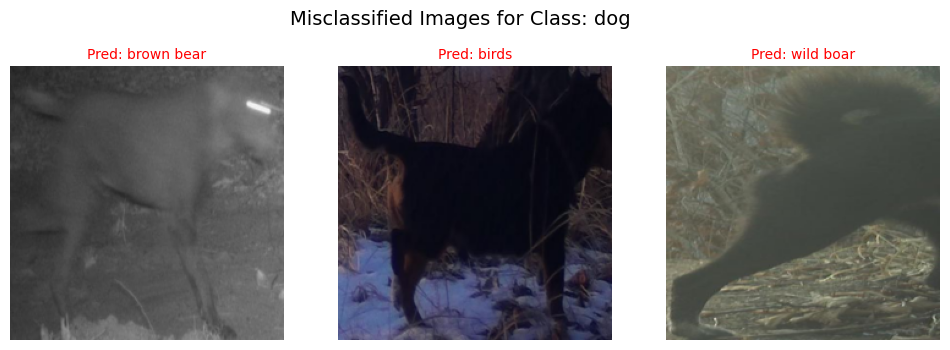

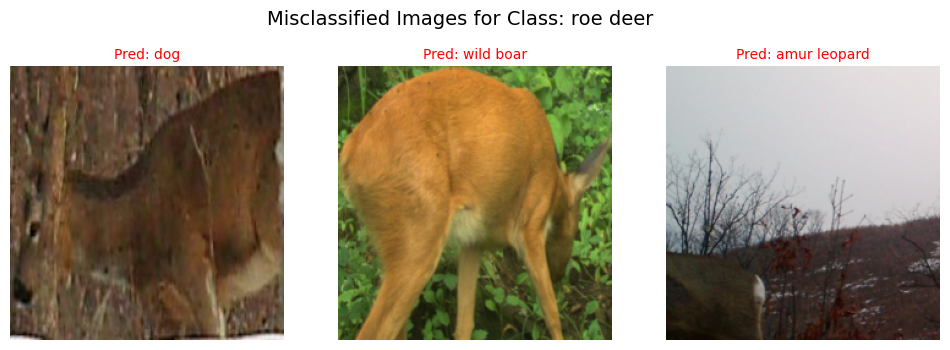

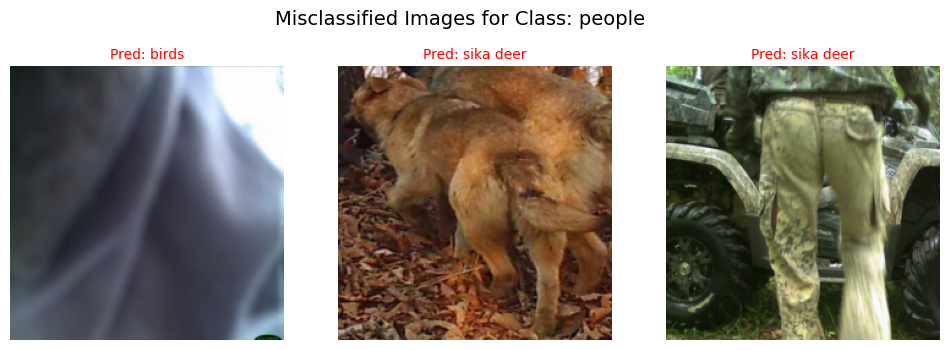

In [22]:
plot_misclassified_images(misclassified, class_names)

In [10]:
wandb.finish()

In [24]:
torch.save(model.state_dict(), "cnn_2_model.pth")

In [12]:
import torchvision.models as models

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        for params in self.model.parameters():
            params.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
        for params in self.model.fc.parameters():
            params.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [15]:
# import torchvision.models as models

# resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# for params in resnet_model.parameters():
#     params.requires_grad = False

# resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)

# for params in resnet_model.fc.parameters():
#     params.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [13]:
resnet_model = ResNet18(10)

In [14]:
resnet_model.to(device)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

In [23]:
run = wandb.init(project='cv-a1-resnet18-finetune-2', config={"epochs": 10, "batch_size": 32, "learning_rate": 0.001})

In [24]:
%%time

_ = train(resnet_model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10 | Train Loss: 1.1363 | Train Acc: 0.6339 | Val Loss: 0.7951 | Val Acc: 0.7502
Epoch 2/10 | Train Loss: 0.7456 | Train Acc: 0.7514 | Val Loss: 0.6817 | Val Acc: 0.7699
Epoch 3/10 | Train Loss: 0.6730 | Train Acc: 0.7731 | Val Loss: 0.6311 | Val Acc: 0.7918
Epoch 4/10 | Train Loss: 0.6185 | Train Acc: 0.7897 | Val Loss: 0.6312 | Val Acc: 0.7798
Epoch 5/10 | Train Loss: 0.5909 | Train Acc: 0.7991 | Val Loss: 0.6092 | Val Acc: 0.7845
Epoch 6/10 | Train Loss: 0.5701 | Train Acc: 0.8033 | Val Loss: 0.5914 | Val Acc: 0.7922
Epoch 7/10 | Train Loss: 0.5513 | Train Acc: 0.8153 | Val Loss: 0.5900 | Val Acc: 0.7965
Epoch 8/10 | Train Loss: 0.5480 | Train Acc: 0.8070 | Val Loss: 0.6054 | Val Acc: 0.7806
Epoch 9/10 | Train Loss: 0.5241 | Train Acc: 0.8208 | Val Loss: 0.5748 | Val Acc: 0.8021
Epoch 10/10 | Train Loss: 0.5225 | Train Acc: 0.8183 | Val Loss: 0.5682 | Val Acc: 0.7978
CPU times: user 1min 23s, sys: 39.7 s, total: 2min 3s
Wall time: 7min 45s


In [25]:
torch.save(resnet_model.state_dict(), "resnet_model.pth")

In [19]:
class ResNetFeatures(models.resnet.ResNet):
    def __init__(self):
        super(ResNetFeatures, self).__init__(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2])
        self.load_state_dict(models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).state_dict())

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

In [27]:
resnet_features = ResNetFeatures().to(device)

In [28]:
def extract_features(loader):
    resnet_features.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            output = resnet_features(inputs)
            features.append(output.cpu().numpy())
            labels.append(label.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels


train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)

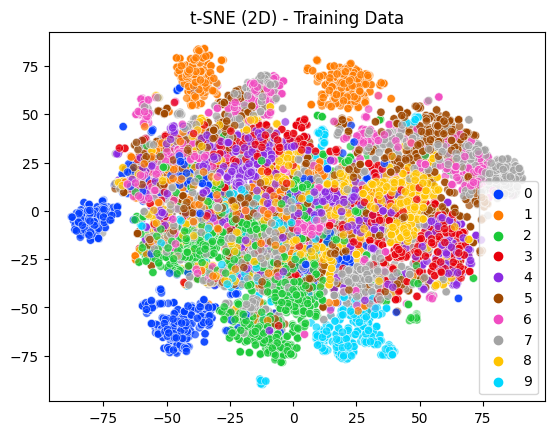

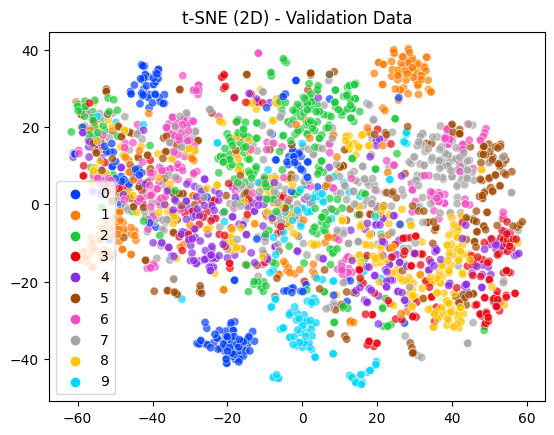

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [29]:
# from mpl_toolkits.mplot3d import Axes3D

def plot_tsne(features, labels, title, n_components=2):
    tsne = TSNE(n_components=n_components, perplexity=30, random_state=42)
    transformed_features = tsne.fit_transform(features)

    if n_components == 2:
        # plt.figure(figsize=(10, 8))
        sns.scatterplot(x=transformed_features[:, 0], y=transformed_features[:, 1], hue=labels, palette="bright", alpha=0.7)
        plt.title(title)
        plt.legend(loc="best")
        plt.show()

        wandb.log({title: wandb.Image(plt)})

    
    elif n_components == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(transformed_features[:, 0], transformed_features[:, 1], transformed_features[:, 2], c=labels, cmap="rainbow", alpha=0.7)
        
        ax.set_title(title)
        ax.set_xlabel("tSNE-1")
        ax.set_ylabel("tSNE-2")
        ax.set_zlabel("tSNE-3")
        plt.colorbar(scatter)
        plt.show()

        wandb.log({title: wandb.Image(plt)})


plot_tsne(train_features, train_labels, title="t-SNE (2D) - Training Data", n_components=2)
plot_tsne(val_features, val_labels, title="t-SNE (2D) - Validation Data", n_components=2)

plot_tsne(val_features, val_labels, title="t-SNE (3D) - Validation Data", n_components=3)

In [30]:
wandb.finish()

In [17]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5)
])

In [18]:
aug_train_dataset1 = RussianWildlifeDataset(train_paths, train_labels, transforms=transform, augment_transform=aug_transform)
aug_train_dataset2 = RussianWildlifeDataset(train_paths, train_labels, transforms=transform, augment_transform=aug_transform)
aug_train_dataset3 = RussianWildlifeDataset(train_paths, train_labels, transforms=transform, augment_transform=aug_transform)

aug_train_loader1 = DataLoader(aug_train_dataset1, batch_size=batch_size, shuffle=True, num_workers=4)
aug_train_loader2 = DataLoader(aug_train_dataset2, batch_size=batch_size, shuffle=True, num_workers=4)
aug_train_loader3 = DataLoader(aug_train_dataset3, batch_size=batch_size, shuffle=True, num_workers=4)

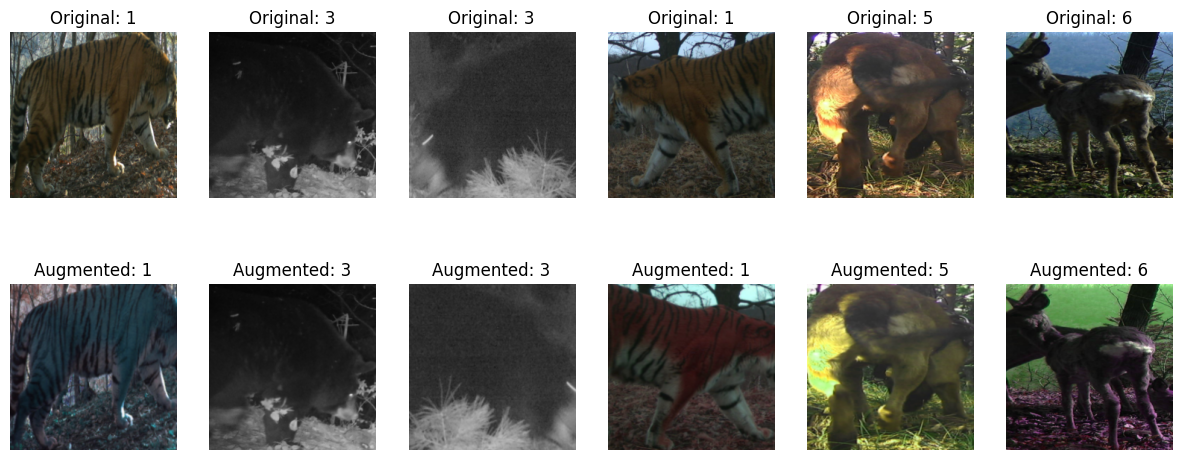

In [19]:
def plot_augmentations(original_data, dataset, num=6):
    fig, axs = plt.subplots(2, num, figsize=(15, 6))

    for i in range(num):
        original, label = original_data[i]
        augmented = dataset[i]

        original_img = original.permute(1, 2, 0).numpy()
        augmented_img = augmented[0].permute(1, 2, 0).numpy()

        axs[0, i].imshow(original_img)
        axs[0, i].set_title(f"Original: {label}")
        axs[0, i].axis("off")

        axs[1, i].imshow(augmented_img)
        axs[1, i].set_title(f"Augmented: {label}")
        axs[1, i].axis("off")

    plt.show()


plot_augmentations(train_dataset, aug_train_dataset1)

In [36]:
# def train_aug(model, train_loader, val_loader, aug1_loader, aug2_loader, criterion, optimizer, epochs=10):
#     for epoch in range(epochs):
#         model.train()
#         cur_loss = 0.0
#         correct, total = 0, 0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
            
#             loss.backward()
#             optimizer.step()

#             cur_loss += loss.item()
#             _, predicted = outputs.max(1)
            
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#         train_loss = cur_loss / len(train_loader)
#         train_acc = correct / total

        
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0

#         all_preds, all_labels = [], []

#         misclassified = {i: [] for i in range(10)}  # Stores misclassified samples
        
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item()
#                 _, predicted = outputs.max(1)
                
#                 val_correct += (predicted == labels).sum().item()
#                 val_total += labels.size(0)

#                 all_preds.extend(predicted.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#                 for i in range(len(labels)):
#                     if predicted[i] != labels[i]:
#                         misclassified[labels[i].item()].append((images[i].cpu(), predicted[i].item()))

#         val_loss /= len(val_loader)
#         val_acc = val_correct / val_total

#         f1 = f1_score(all_labels, all_preds, average="weighted")
#         cm = confusion_matrix(all_labels, all_preds)
#         cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
#         wandb.log({
#             "Epoch": epoch + 1,
#             "Train Loss": train_loss, "Train Acc": train_acc,
#             "Val Loss": val_loss, "Val Acc": val_acc,
#             "Val F1-Score": f1,
#             "Confusion Matrix": wandb.Table(dataframe=cm_df)
#         })

#         print(f"Epoch {epoch+1}/{20+epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

#     for epoch in range(10, 10 + epochs):
#         model.train()
#         cur_loss = 0.0
#         correct, total = 0, 0

#         for images, labels in aug1_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
            
#             loss.backward()
#             optimizer.step()

#             cur_loss += loss.item()
#             _, predicted = outputs.max(1)
            
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#         train_loss = cur_loss / len(train_loader)
#         train_acc = correct / total

        
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0

#         all_preds, all_labels = [], []

#         misclassified = {i: [] for i in range(10)}  # Stores misclassified samples
        
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item()
#                 _, predicted = outputs.max(1)
                
#                 val_correct += (predicted == labels).sum().item()
#                 val_total += labels.size(0)

#                 all_preds.extend(predicted.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#                 for i in range(len(labels)):
#                     if predicted[i] != labels[i]:
#                         misclassified[labels[i].item()].append((images[i].cpu(), predicted[i].item()))

#         val_loss /= len(val_loader)
#         val_acc = val_correct / val_total

#         f1 = f1_score(all_labels, all_preds, average="weighted")
#         cm = confusion_matrix(all_labels, all_preds)
#         cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
#         wandb.log({
#             "Epoch": epoch + 1,
#             "Train Loss": train_loss, "Train Acc": train_acc,
#             "Val Loss": val_loss, "Val Acc": val_acc,
#             "Val F1-Score": f1,
#             "Confusion Matrix": wandb.Table(dataframe=cm_df)
#         })

#         print(f"Epoch {epoch+1}/{20+epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

#     for epoch in range(20, 20 + epochs):
#         model.train()
#         cur_loss = 0.0
#         correct, total = 0, 0

#         for images, labels in aug2_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
            
#             loss.backward()
#             optimizer.step()

#             cur_loss += loss.item()
#             _, predicted = outputs.max(1)
            
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#         train_loss = cur_loss / len(train_loader)
#         train_acc = correct / total

        
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0

#         all_preds, all_labels = [], []

#         misclassified = {i: [] for i in range(10)}  # Stores misclassified samples
        
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item()
#                 _, predicted = outputs.max(1)
                
#                 val_correct += (predicted == labels).sum().item()
#                 val_total += labels.size(0)

#                 all_preds.extend(predicted.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#                 for i in range(len(labels)):
#                     if predicted[i] != labels[i]:
#                         misclassified[labels[i].item()].append((images[i].cpu(), predicted[i].item()))

#         val_loss /= len(val_loader)
#         val_acc = val_correct / val_total

#         f1 = f1_score(all_labels, all_preds, average="weighted")
#         cm = confusion_matrix(all_labels, all_preds)
#         cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
#         wandb.log({
#             "Epoch": epoch + 1,
#             "Train Loss": train_loss, "Train Acc": train_acc,
#             "Val Loss": val_loss, "Val Acc": val_acc,
#             "Val F1-Score": f1,
#             "Confusion Matrix": wandb.Table(dataframe=cm_df)
#         })

#         print(f"Epoch {epoch+1}/{20+epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

#     return misclassified

In [20]:
def train_aug(model, train_loader, val_loader, aug1_loader, aug2_loader, aug3_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        cur_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            _, predicted = outputs.max(1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = cur_loss / len(train_loader)
        train_acc = correct / total

        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        f1 = f1_score(all_labels, all_preds, average="weighted")
        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
        wandb.log({
            "Epoch": 4*epoch + 1,
            "Train Loss": train_loss, "Train Acc": train_acc,
            "Val Loss": val_loss, "Val Acc": val_acc,
            "Val F1-Score": f1,
            "Confusion Matrix": wandb.Table(dataframe=cm_df)
        })

        print(f"Epoch {4*epoch+1}/{30+epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


        model.train()
        cur_loss = 0.0
        correct, total = 0, 0

        for images, labels in aug1_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            _, predicted = outputs.max(1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = cur_loss / len(train_loader)
        train_acc = correct / total

        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        f1 = f1_score(all_labels, all_preds, average="weighted")
        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
        wandb.log({
            "Epoch": 4*epoch + 2,
            "Train Loss": train_loss, "Train Acc": train_acc,
            "Val Loss": val_loss, "Val Acc": val_acc,
            "Val F1-Score": f1,
            "Confusion Matrix": wandb.Table(dataframe=cm_df)
        })

        print(f"Epoch {4*epoch+2}/{30+epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


        model.train()
        cur_loss = 0.0
        correct, total = 0, 0

        for images, labels in aug2_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            _, predicted = outputs.max(1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = cur_loss / len(train_loader)
        train_acc = correct / total

        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        f1 = f1_score(all_labels, all_preds, average="weighted")
        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
        wandb.log({
            "Epoch": 4*epoch + 3,
            "Train Loss": train_loss, "Train Acc": train_acc,
            "Val Loss": val_loss, "Val Acc": val_acc,
            "Val F1-Score": f1,
            "Confusion Matrix": wandb.Table(dataframe=cm_df)
        })

        print(f"Epoch {4*epoch+3}/{30+epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        model.train()
        cur_loss = 0.0
        correct, total = 0, 0

        for images, labels in aug3_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            _, predicted = outputs.max(1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = cur_loss / len(train_loader)
        train_acc = correct / total

        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        f1 = f1_score(all_labels, all_preds, average="weighted")
        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())

        
        wandb.log({
            "Epoch": 4*epoch + 4,
            "Train Loss": train_loss, "Train Acc": train_acc,
            "Val Loss": val_loss, "Val Acc": val_acc,
            "Val F1-Score": f1,
            "Confusion Matrix": wandb.Table(dataframe=cm_df)
        })

        print(f"Epoch {4*epoch+4}/{30+epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

In [21]:
resnet_aug_model = ResNet18(10)

resnet_aug_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_aug_model.parameters(), lr=0.001)

In [22]:
run = wandb.init(project='cv-a1-resnet18-aug', config={"epochs": 10, "batch_size": 32, "learning_rate": 0.001})

In [23]:
%%time

_ = train_aug(resnet_aug_model, train_loader, val_loader, aug_train_loader1, aug_train_loader2, aug_train_loader3, criterion, optimizer, epochs=10)

Epoch 1/40 | Train Loss: 1.1295 | Train Acc: 0.6430 | Val Loss: 0.8221 | Val Acc: 0.7301
Epoch 2/40 | Train Loss: 0.9524 | Train Acc: 0.6745 | Val Loss: 0.7612 | Val Acc: 0.7335
Epoch 3/40 | Train Loss: 0.8386 | Train Acc: 0.7106 | Val Loss: 0.7318 | Val Acc: 0.7395
Epoch 4/40 | Train Loss: 0.8220 | Train Acc: 0.7188 | Val Loss: 0.7076 | Val Acc: 0.7506
Epoch 5/40 | Train Loss: 0.6461 | Train Acc: 0.7799 | Val Loss: 0.6179 | Val Acc: 0.7922
Epoch 6/40 | Train Loss: 0.7811 | Train Acc: 0.7279 | Val Loss: 0.6764 | Val Acc: 0.7614
Epoch 7/40 | Train Loss: 0.7542 | Train Acc: 0.7386 | Val Loss: 0.6628 | Val Acc: 0.7631
Epoch 8/40 | Train Loss: 0.7387 | Train Acc: 0.7430 | Val Loss: 0.6636 | Val Acc: 0.7721
Epoch 9/40 | Train Loss: 0.6034 | Train Acc: 0.7869 | Val Loss: 0.5960 | Val Acc: 0.7875
Epoch 10/40 | Train Loss: 0.7260 | Train Acc: 0.7464 | Val Loss: 0.6385 | Val Acc: 0.7841
Epoch 11/40 | Train Loss: 0.7271 | Train Acc: 0.7457 | Val Loss: 0.6875 | Val Acc: 0.7609
Epoch 12/40 | Train

In [24]:
torch.save(resnet_aug_model.state_dict(), "resnet_aug_model.pth")

In [25]:
wandb.finish()

In [ ]:
# To load model:
# model.load_state_dict(torch.load(PATH, weights_only=True))